In [1]:
from PIL import Image
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, AdamW
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler

import torch
import torch.nn.functional as F
import argparse
import os
from generation_utils import debias_vl_set, txt_process, bias_prompt, AttackTarget, create_prompts_and_index_mapping, train_list, test_list
from copy import deepcopy as dc
class Args:
    cls = "a photo of a waterbird"  # target class name
    lam = 100.0  # regularizer constant
    mode = "base"  # mode options: ['debias_vl', 'base', 'debias_vl_bias']
    use = "base"  # use options: ['debias_vl', 'base', 'fairerclip']
    revision = None  # Revision of pretrained model identifier from huggingface.co/models
    bias = "background"  # Bias type
    epochs = 100  # Number of epochs
    alpha = 0.3  # Alpha value
    pretrained_model_name_or_path = "stabilityai/stable-diffusion-2-1-base"  # Path to pretrained model
    config_file = "configs/debias_waterbird_mode.yaml"  # Path to config file
    model = "clip_ViTL14"  # Model type
    pretrained_vae_name_or_path = None  # Path to pretrained VAE

In [2]:
# Instantiate args
args = Args()
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
batch_size = 1
alpha = 0.3
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2-1-base"
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer" )
text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder" )
text_encoder = text_encoder.to(torch_device)

target_model = AttackTarget(text_encoder, 1, torch_device).to(torch_device)
optimizer = AdamW(filter(lambda p: p.requires_grad, target_model.parameters()), lr=5e-5)
# peft tuning
sub = torch.tensor(0, device=torch_device).float()

/home/connor/.conda/envs/fair/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/connor/.conda/envs/fair/lib/python3.9/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [3]:

height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
batch_size = 1
alpha = args.alpha

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained(args.pretrained_model_name_or_path,
                                          subfolder="tokenizer", revision=args.revision, )
text_encoder = CLIPTextModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision, )
text_encoder = text_encoder.to(torch_device)

target_model = AttackTarget(text_encoder, 1, torch_device).to(torch_device)
optimizer = AdamW(filter(lambda p: p.requires_grad, target_model.parameters()), lr=5e-5)
# peft tuning
sub = torch.tensor(0, device=torch_device).float()

templates = ['a photo of']  # 'this is a picture of',
retain_content = [j.lower() for j in train_list]
bias_content = ['male', 'female']

retain_prompt, bias_prompt, candidate_prompt, index_mapping = (
    create_prompts_and_index_mapping(templates, retain_content, bias_content, type='gender'))

with torch.no_grad():
    z0 = txt_process(retain_prompt, text_encoder, tokenizer, torch_device)
    z0_mix = txt_process(candidate_prompt, text_encoder, tokenizer, torch_device)
    z0_bias = txt_process(bias_prompt, text_encoder, tokenizer, torch_device)
candidate_set = {
    idx: tokenizer(text=candidate_prompt[idx], padding='max_length', return_tensors="pt", truncation=True).to(
        torch_device) for idx in range(len(candidate_prompt))
}
use_ = 'bias'


def create_attention_mask(input_shape):
    # Create a causal attention mask for CLIP
    batch_size, seq_len = input_shape
    mask = torch.full((batch_size, 1, seq_len, seq_len), float("-inf"))
    mask = torch.triu(mask, diagonal=1)
    mask = mask.to('cuda' if torch.cuda.is_available() else 'cpu')
    return mask


with torch.no_grad():
    token_, ret_mask = target_model.tokenizer(tokenizer, retain_prompt)
    check_ = token_['input_ids'].argmax(-1)
    wz_feature = target_model.get_feature(token_.input_ids, ret_mask)
    candi_token_, cand_mask = target_model.tokenizer(tokenizer, candidate_prompt)
    z_diff_feature = target_model.get_feature(candi_token_.input_ids, cand_mask)
    bias_token_, bias_mask = target_model.tokenizer(tokenizer, bias_prompt)
    z_diff_bias_feature = target_model.get_feature(bias_token_.input_ids, bias_mask)
    mix_eos_ind = candi_token_['input_ids'].argmax(-1)

target_len, token_len, dim = z0.shape
mix_len, bias_len = z0_mix.size(0), z0_bias.size(0)
ind_target, ind_bias, ind_mix = token_['input_ids'], bias_token_['input_ids'], candi_token_['input_ids']
z0_tar_eos = F.normalize(z0[torch.arange(target_len), ind_target.argmax(-1)], dim=-1)
z0_mix_eos = F.normalize(z0_mix[torch.arange(z0_mix.shape[0]), candi_token_['input_ids'].argmax(-1)], dim=-1)
z0_bias_eos = F.normalize(z0_bias[torch.arange(z0_bias.shape[0]), bias_token_['input_ids'].argmax(-1)], dim=-1)
min_value = z0_tar_eos[0].detach() @ z0_tar_eos[1].detach().T


/tmp/ipykernel_1647441/1030931025.py:63: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  min_value = z0_tar_eos[0].detach() @ z0_tar_eos[1].detach().T


In [11]:
equalization_loss, distil_loss, target_loss, match = dc(sub), dc(sub), dc(sub), dc(sub)
equal_loss_adv, distil_loss_adv, cnt = dc(sub), dc(sub), 0
optimizer.zero_grad()

z_tar = target_model(wz_feature)
for wz_, z0_ in zip(z_tar, z0):
    distil_loss += F.mse_loss(wz_, z0_).to(torch_device)

z_tar_eos = F.normalize(z_tar[torch.arange(z_tar.shape[0]), check_], dim=-1)

z_mix = target_model(z_diff_feature)
z_mix_eos = F.normalize(z_mix[torch.arange(z_mix.shape[0]), mix_eos_ind], dim=-1)
sim_mix_mix = z_mix_eos @ z0_mix_eos.T
sim_mix_bias0 = z_mix_eos @ z0_bias_eos.T
sim_tar_bias0 = z_tar @ z0_bias_eos.T
sim_tar_mix = z_tar_eos @ z0_mix_eos.T
match += F.mse_loss(sim_tar_bias0[:, 0], sim_tar_bias0[:, 1])

In [85]:
with torch.no_grad():
    z0 = txt_process(retain_prompt, text_encoder, tokenizer, torch_device)
    z_diff = txt_process(candidate_prompt, text_encoder, tokenizer, torch_device)
    z_diff_bias = txt_process(bias_prompt, text_encoder, tokenizer, torch_device)
candidate_set = {
    idx: tokenizer(text=candidate_prompt[idx], padding='max_length', return_tensors="pt", truncation=True).to(
        torch_device) for idx in range(len(candidate_prompt))
}
use_ = 'bias'

def create_attention_mask(input_shape):
    # Create a causal attention mask for CLIP
    batch_size, seq_len = input_shape
    mask = torch.full((batch_size, 1, seq_len, seq_len), float("-inf"))
    mask = torch.triu(mask, diagonal=1)
    mask = mask.to('cuda' if torch.cuda.is_available() else 'cpu')
    return mask


with torch.no_grad():
    token_, ret_mask = target_model.tokenizer(tokenizer, retain_prompt)
    check_ = token_['input_ids'].argmax(-1)
    wz_feature = target_model.get_feature(token_.input_ids, ret_mask)
    candi_token_, cand_mask = target_model.tokenizer(tokenizer, candidate_prompt)
    z_diff_feature = target_model.get_feature(candi_token_.input_ids, cand_mask)
    bias_token_, bias_mask = target_model.tokenizer(tokenizer, bias_prompt)
    z_diff_bias_feature = target_model.get_feature(bias_token_.input_ids, bias_mask)

target_len, token_len, dim = z0.shape
mix_len, bias_len = z_diff.size(0), z_diff_bias.size(0)
ind_target, ind_bias, ind_mix = token_['input_ids'], bias_token_['input_ids'], candi_token_['input_ids']
z0_tar_eos = F.normalize(z0[torch.arange(target_len), ind_target.argmax(-1)], dim=-1)
z0_mix_eos = F.normalize(z_diff[torch.arange(z_diff.shape[0]), candi_token_['input_ids'].argmax(-1)], dim=-1)
z0_bias_eos = F.normalize(z_diff_bias[torch.arange(z_diff_bias.shape[0]), bias_token_['input_ids'].argmax(-1)],
                          dim=-1)
min_value = z0_tar_eos[0].detach() @ z0_tar_eos[1].detach().T

indices_1 = torch.tensor([[1] * 7 + [0] * 7, [0] * 7 + [0] * 7], device=torch_device, dtype=torch.bool)
indices_2 = torch.tensor([[0] * 7 + [0] * 7, [0] * 7 + [1] * 7], device=torch_device, dtype=torch.bool)
indices_3 = torch.tensor([[0] * 2 + [1] * 2, [1] * 2 + [0] * 2], device=torch_device, dtype=torch.bool)

# tar - mix
sim_tar0_mix0 = (z0_tar_eos @ z0_mix_eos.T)
# tar - tar
sim_tar0_tar0 = (z0_tar_eos @ z0_tar_eos.T)
# mix - mix
sim_mix0_mix0 = (z0_mix_eos @ z0_mix_eos.T)
# tar - bias
sim_tar0_bias0 = z0_tar_eos @ z0_bias_eos.T

In [29]:
z_tar_eos[:20]

torch.Size([81, 1024])

In [34]:
candidate_prompt

['a photo of a male actor',
 'a photo of a female actor',
 'a photo of a male architect',
 'a photo of a female architect',
 'a photo of a male audiologist',
 'a photo of a female audiologist',
 'a photo of a male author',
 'a photo of a female author',
 'a photo of a male baker',
 'a photo of a female baker',
 'a photo of a male barber',
 'a photo of a female barber',
 'a photo of a male blacksmith',
 'a photo of a female blacksmith',
 'a photo of a male bricklayer',
 'a photo of a female bricklayer',
 'a photo of a male bus driver',
 'a photo of a female bus driver',
 'a photo of a male butcher',
 'a photo of a female butcher',
 'a photo of a male chef',
 'a photo of a female chef',
 'a photo of a male chemist',
 'a photo of a female chemist',
 'a photo of a male cleaner',
 'a photo of a female cleaner',
 'a photo of a male coach',
 'a photo of a female coach',
 'a photo of a male comedian',
 'a photo of a female comedian',
 'a photo of a male computer programmer',
 'a photo of a fem

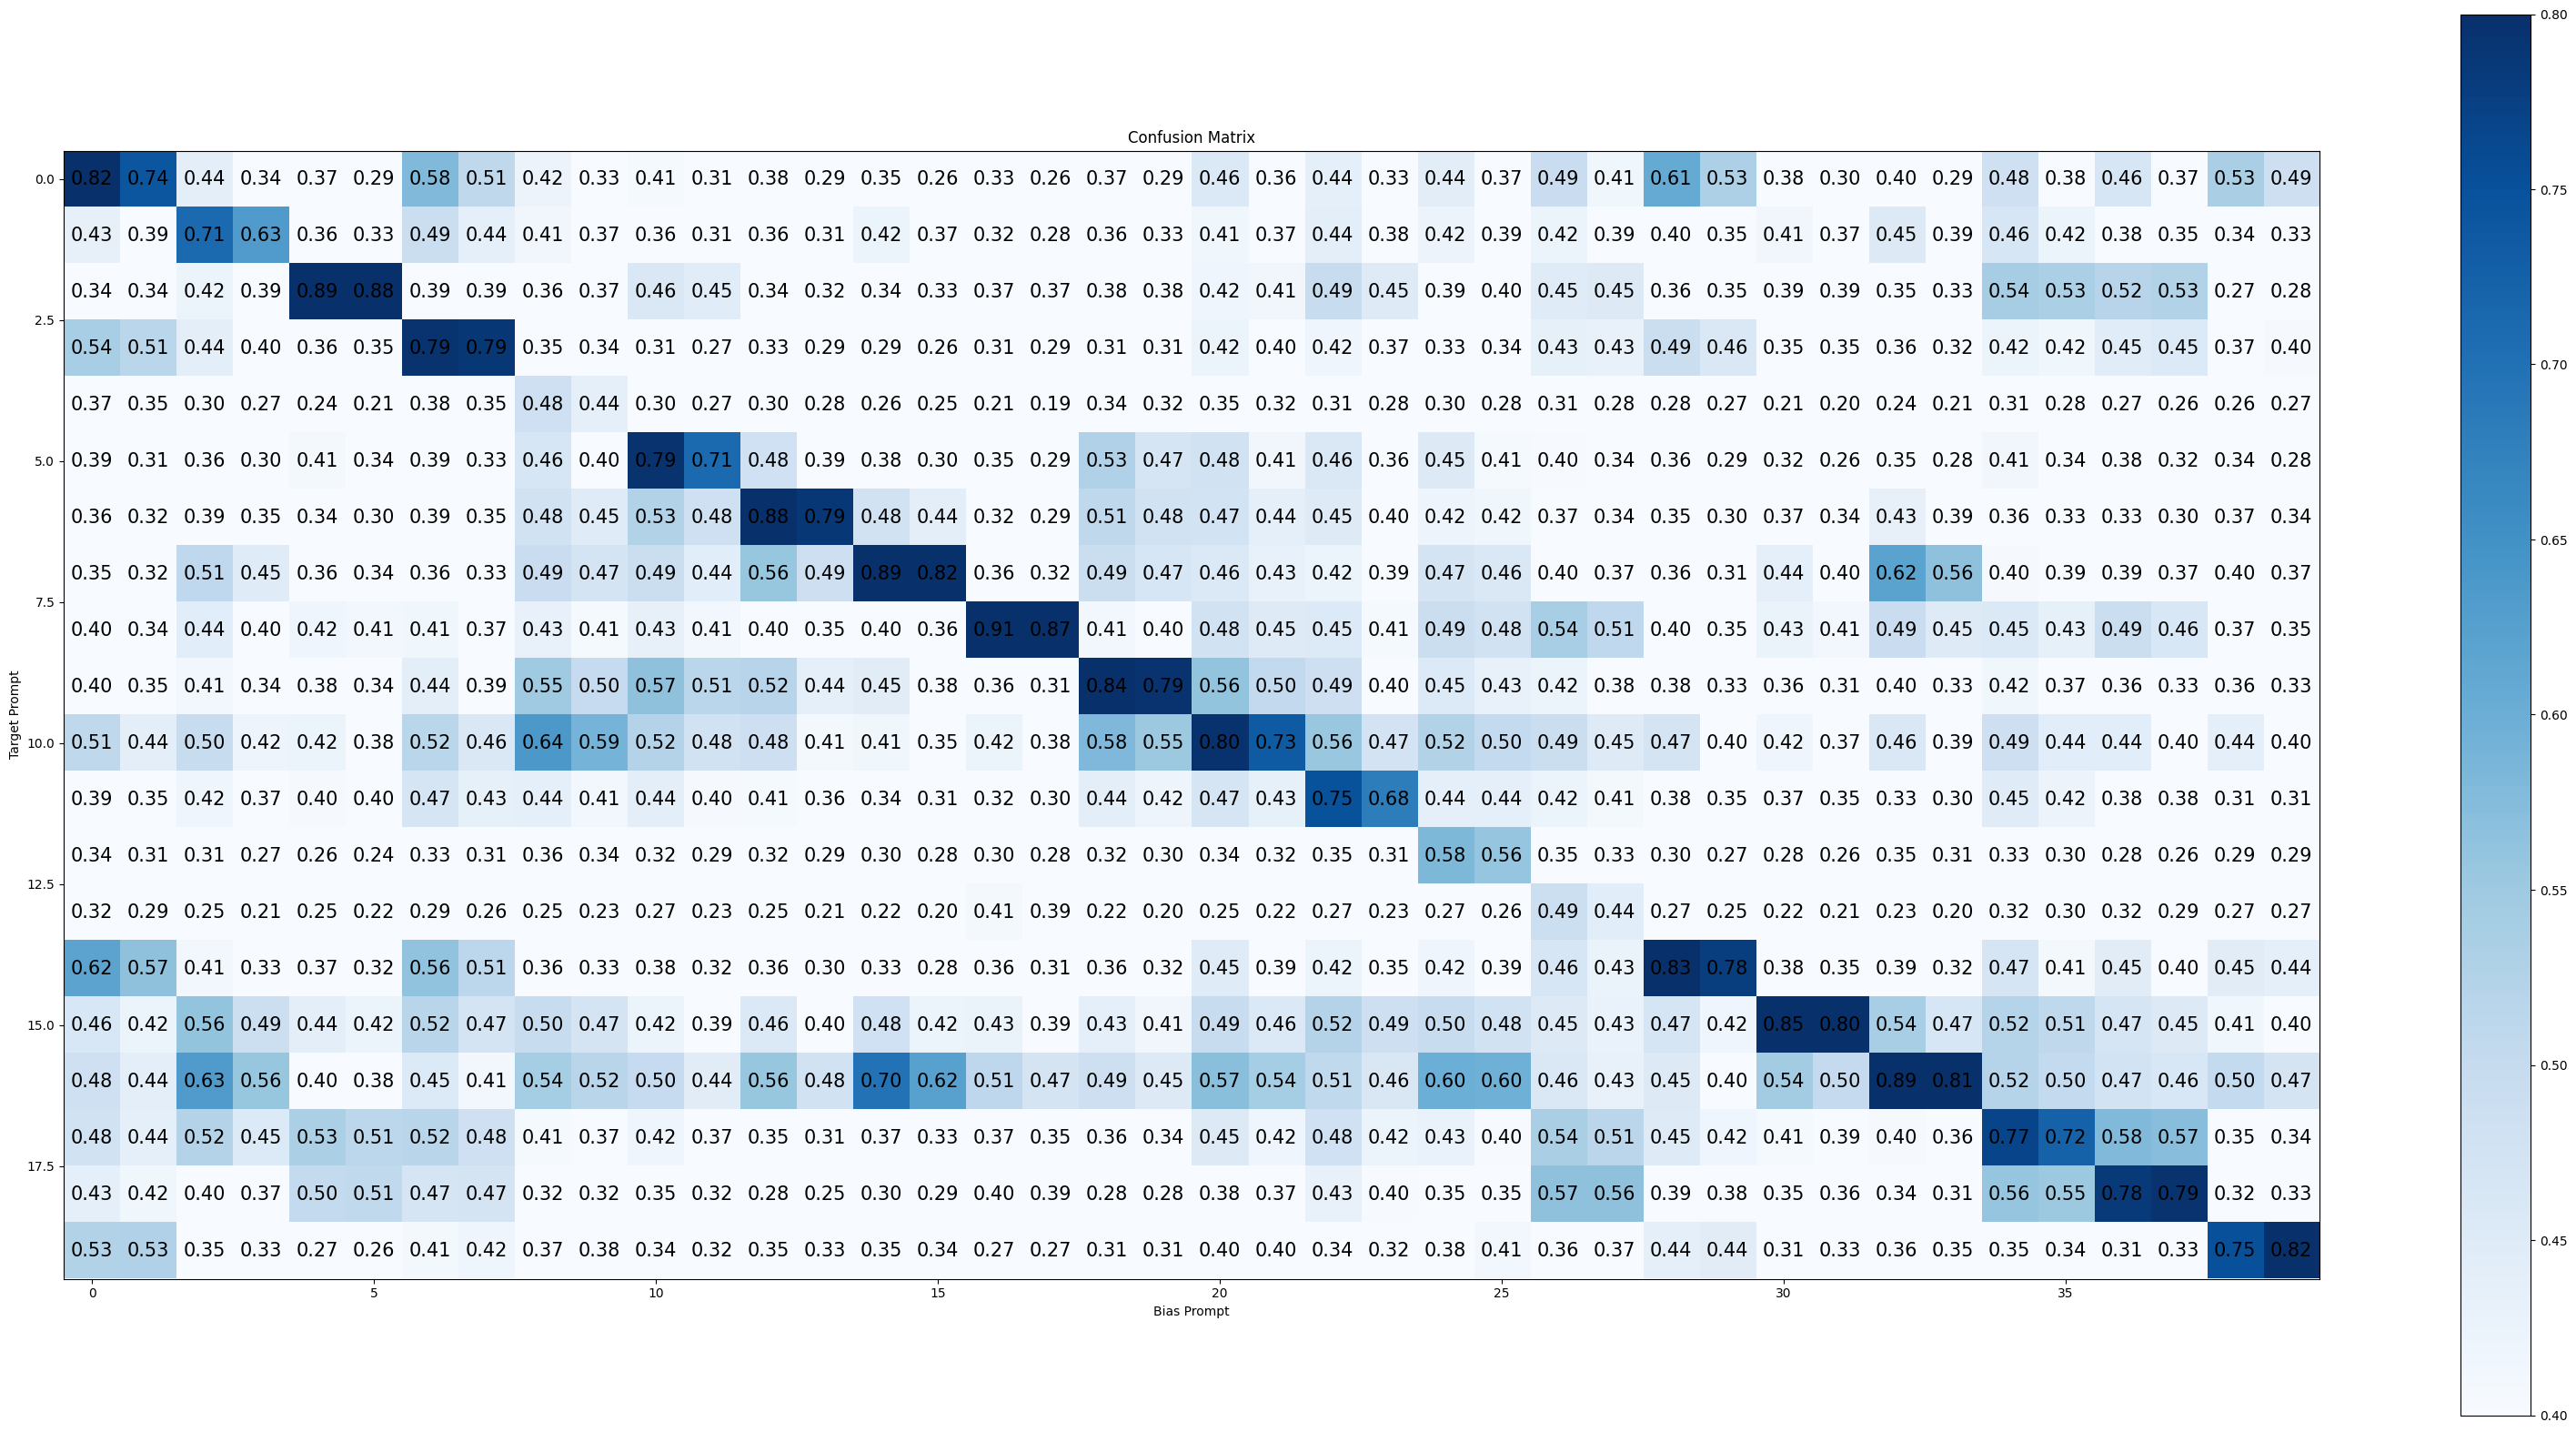

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

sim_tar_mix = (z_tar_eos[:20] @ z_mix_eos[:40].T)

plt.figure(figsize=(40, 20))
norm = mcolors.TwoSlopeNorm(vmin=0.4, vcenter=0.6, vmax=0.8)
plt.imshow(sim_tar_mix.cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.Blues, norm=norm)
for (i, j), val in np.ndenumerate(sim_tar_mix.cpu().detach().cpu()):
    if val != 0:
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=15)
plt.colorbar()

plt.title('Confusion Matrix')
plt.xlabel('Bias Prompt')
plt.ylabel('Target Prompt')

plt.show()

In [43]:
sim_tar_mix.shape

torch.Size([20, 40])

In [53]:

for i in indices:
    # Positive 인덱스의 최소값
    pos_min = torch.min(sim_tar_mix[i, 2*i:2*i+2])
    positive_min.append(pos_min.item())
    
    # Negative 인덱스의 최대값
    neg_max = torch.max(sim_tar_mix[i, 2*i+2:])
    negative_max.append(neg_max.item())

RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [42]:
import torch
import matplotlib.pyplot as plt


# Positive 및 Negative 값 계산
indices = torch.arange(81)
positive_min = []
negative_max = []

for i in indices:
    # Positive 인덱스의 최소값
    pos_min = torch.min(sim_tar_mix[i, 2*i:2*i+2])
    positive_min.append(pos_min.item())
    
    # Negative 인덱스의 최대값
    neg_max = torch.max(sim_tar_mix[i, 2*i+2:])
    negative_max.append(neg_max.item())

# 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(indices, positive_min, 'ro-', label='Positive Min (Red)')
plt.plot(indices, negative_max, 'yo-', label='Negative Max (Yellow)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Positive Min vs. Negative Max per Index')
plt.legend()
plt.show()

RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

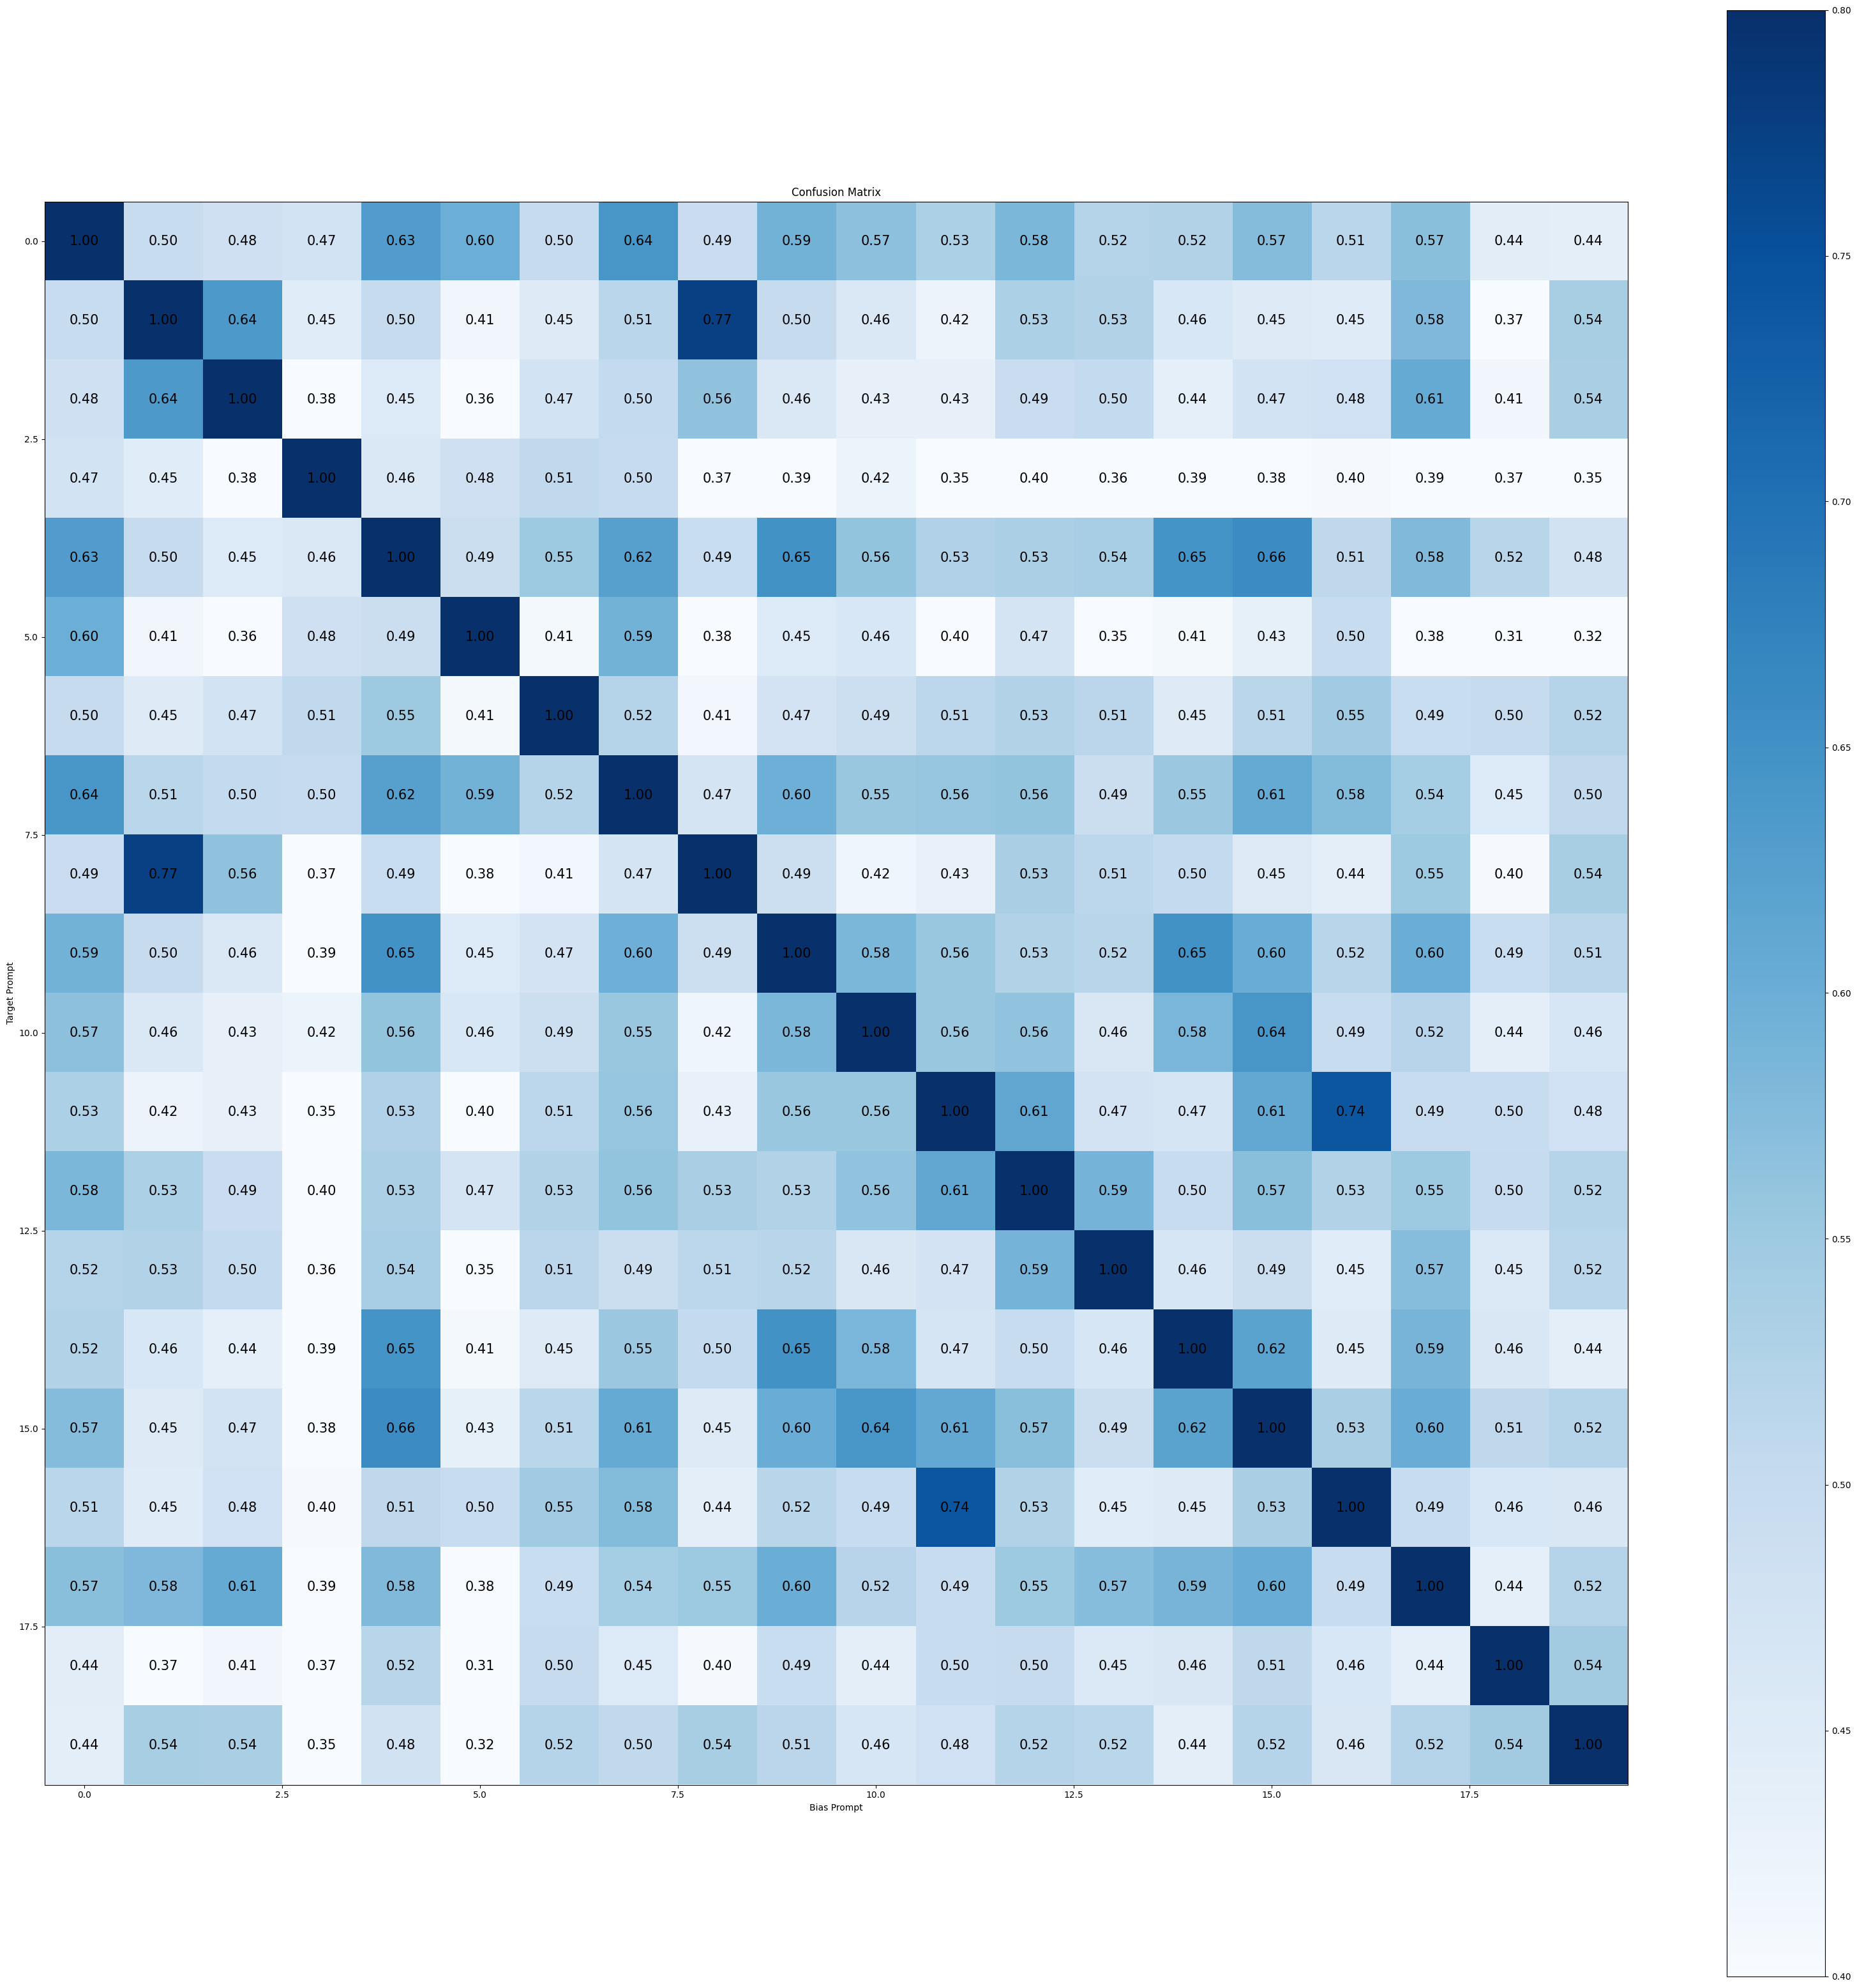

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
plt.figure(figsize=(40, 40))
norm = mcolors.TwoSlopeNorm(vmin=0.4, vcenter=0.6, vmax=0.8)
plt.imshow(sim_tar0_tar0.cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.Blues, norm=norm)
for (i, j), val in np.ndenumerate(sim_tar0_tar0.cpu()):
    if val != 0:
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=15)
plt.colorbar()

plt.title('Confusion Matrix')
plt.xlabel('Bias Prompt')
plt.ylabel('Target Prompt')

plt.show()

In [97]:
candidate_prompt

['a photo of a male architect',
 'a photo of a female architect',
 'a photo of a male barber',
 'a photo of a female barber',
 'a photo of a male butcher',
 'a photo of a female butcher',
 'a photo of a male coach',
 'a photo of a female coach',
 'a photo of a male consultant',
 'a photo of a female consultant',
 'a photo of a male designer',
 'a photo of a female designer',
 'a photo of a male driver',
 'a photo of a female driver',
 'a photo of a male entrepreneur',
 'a photo of a female entrepreneur',
 'a photo of a male hairdresser',
 'a photo of a female hairdresser',
 'a photo of a male lawyer',
 'a photo of a female lawyer',
 'a photo of a male mathematician',
 'a photo of a female mathematician',
 'a photo of a male musician',
 'a photo of a female musician',
 'a photo of a male painter',
 'a photo of a female painter',
 'a photo of a male plumber',
 'a photo of a female plumber',
 'a photo of a male psychologist',
 'a photo of a female psychologist',
 'a photo of a male resear

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
plt.figure(figsize=(10, 20))
norm = mcolors.TwoSlopeNorm(vmin=0.2, vcenter=0.4, vmax=0.6)
plt.imshow(sim_tar0_bias0.cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.Blues, norm=norm)
for (i, j), val in np.ndenumerate(sim_tar0_bias0.cpu()):
    if val != 0:
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=10)
plt.colorbar()

plt.title('Confusion Matrix')
plt.xlabel('Bias Prompt')
plt.ylabel('Target Prompt')

plt.show()

['architect',
 'barber',
 'butcher',
 'coach',
 'consultant',
 'designer',
 'driver',
 'entrepreneur',
 'hairdresser',
 'lawyer',
 'mathematician',
 'musician',
 'painter',
 'plumber',
 'psychologist',
 'researcher',
 'singer',
 'surgeon',
 'tour guide',
 'waiter']

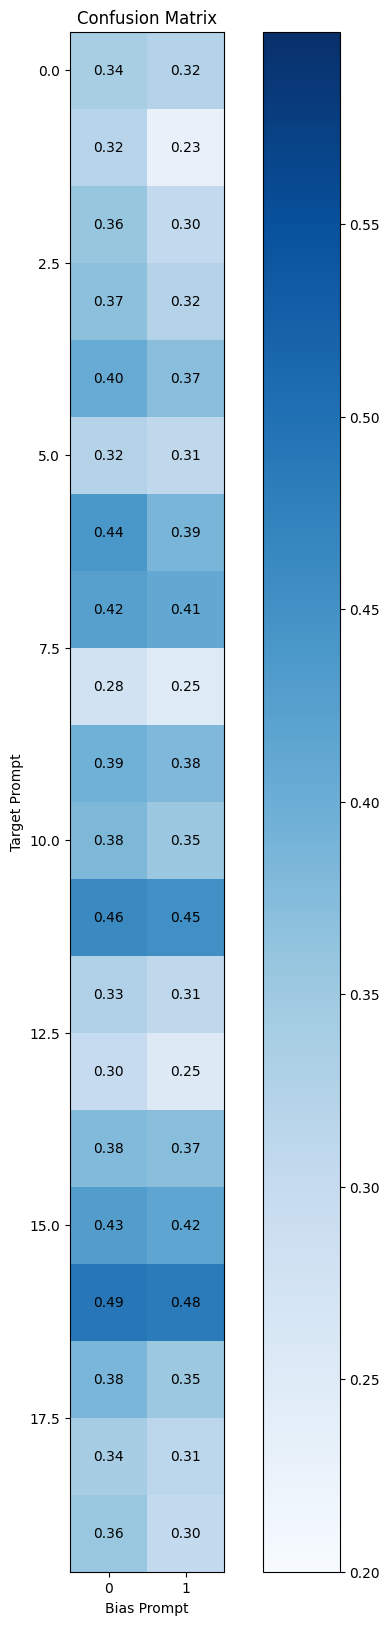

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
plt.figure(figsize=(10, 20))
norm = mcolors.TwoSlopeNorm(vmin=0.2, vcenter=0.4, vmax=0.6)
plt.imshow(sim_tar0_bias0.cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.Blues, norm=norm)
for (i, j), val in np.ndenumerate(sim_tar0_bias0.cpu()):
    if val != 0:
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=10)
plt.colorbar()

plt.title('Confusion Matrix')
plt.xlabel('Bias Prompt')
plt.ylabel('Target Prompt')

plt.show()

In [ ]:
ind_ = torch.eye(7, dtype=torch.bool)
ind_2 = torch.cat([torch.eye(7, dtype=torch.bool), torch.eye(7, dtype=torch.bool)])
indices_1 = torch.tensor([[1] * 7 + [0] * 7, [0] * 7 + [0] * 7], device=torch_device, dtype=torch.bool)
indices_2 = torch.tensor([[0] * 7 + [0] * 7, [0] * 7 + [1] * 7], device=torch_device, dtype=torch.bool)
indices_3 = torch.tensor([[0] * 7 + [1] * 7, [1] * 7 + [0] * 7], device=torch_device, dtype=torch.bool)

# mix - mix

sim_mix0_mix0_right = (z0_mix_eos[:7] @ z0_mix_eos[7:].T)[ind_]
sim_mix0_mix0_wrong = (z0_mix_eos[:7] @ z0_mix_eos[7:].T)[~ind_]
# tar - mix
sim_tar0_mix0 = (z0_tar_eos @ z0_mix_eos.T)
sim_tar0_mix0_right = sim_tar0_mix0[~indices_3]
sim_tar0_mix0_wrong = sim_tar0_mix0[indices_3]
# bias
sim_tar0_bias0 = z0_tar_eos @ z0_bias_eos.T
# mix - bias
sim_mix0_bias0 = (z0_mix_eos @ z0_bias_eos.T)
sim_mix0_bias0_right = sim_mix0_bias0[ind_2]
sim_mix0_bias0_wrong = sim_mix0_bias0[~ind_2]
a_0, a_1 = sim_mix0_bias0_right.split(7)
sim_new_type = ((z0_mix_eos @ z0_bias_eos.T)[ind_2] + min_value) / 2
right_min = torch.cat([sim_tar0_mix0_right, sim_mix0_mix0_right]).min()
wrong_max = torch.cat([sim_tar0_mix0_wrong, sim_mix0_mix0_wrong]).max()
print(f'ck_list : mix_r {int(sim_mix0_mix0_right.mean() * 100)}, w {int(sim_mix0_mix0_wrong.mean() * 100)}'
      f'| tar_mix_r {int(sim_tar0_mix0_right.mean() * 100)}, w {int(sim_tar0_mix0_wrong.mean() * 100)}'
      f'| mix_bias_r {int(sim_mix0_bias0_right.mean() * 100)}, w {int(sim_mix0_bias0_wrong.mean() * 100)}'
      f'| tar_bias {int(sim_tar0_bias0.mean() * 100)}')

sim_mix0_mix0 = z0_mix_eos @ z0_mix_eos.T
ind_ = torch.eye(7, dtype=torch.bool)
first_class_indices = torch.triu_indices(7, 7, 1)
first_class_indices2 = torch.triu_indices(7, 7, 1) + 7
first_class_similarity =  torch.cat([sim_mix0_mix0[first_class_indices[0], first_class_indices[1]], sim_mix0_mix0[first_class_indices2[0], first_class_indices2[1]],sim_mix0_mix0[first_class_indices[1], first_class_indices[0]], sim_mix0_mix0[first_class_indices2[1], first_class_indices2[0]]])

second_class_indices = (torch.arange(7), torch.arange(7) + 7)
second_class_similarity = torch.cat([sim_mix0_mix0[second_class_indices[0], second_class_indices[1]],sim_mix0_mix0[second_class_indices[1], second_class_indices[0]]])
other_similarity_mask = ~torch.eye(14, dtype=torch.bool) & ~(torch.triu(torch.ones(14, 14), 1).bool())
other_similarity = sim_mix0_mix0[other_similarity_mask]

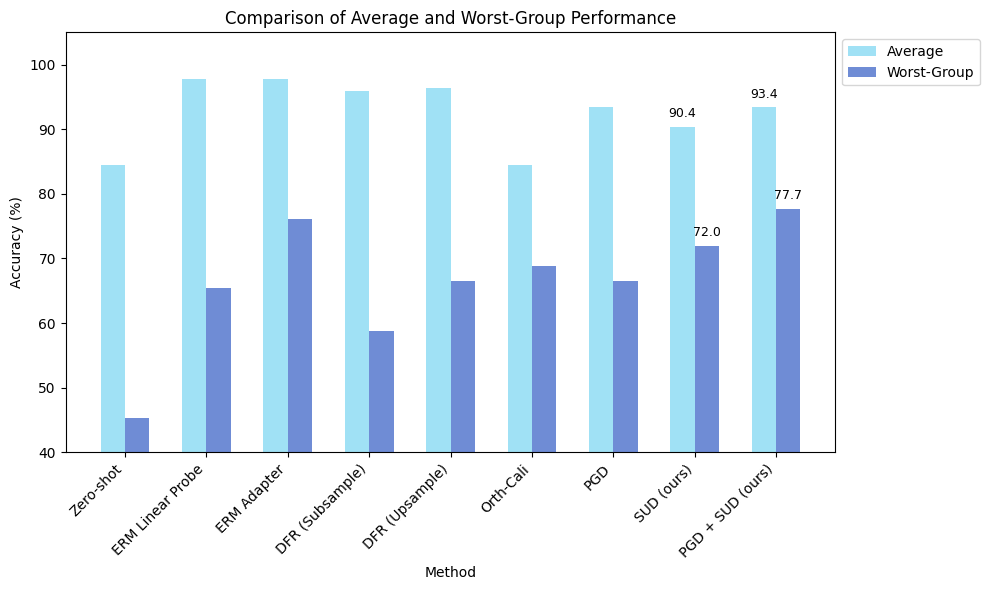

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
methods_line_chart = [
    "Zero-shot", "ERM Linear Probe", "ERM Adapter", 
    "DFR (Subsample)", "DFR (Upsample)", "Orth-Cali", 
    "PGD", "SUD (ours)", "PGD + SUD (ours)"
]

wg_values_line = [45.3, 65.4, 76.1, 58.8, 66.5, 68.8, 66.5, 72.0, 77.7]
avg_values_line = [84.4, 97.7, 97.8, 95.9, 96.4, 84.5, 93.4, 90.4, 93.4]

# 그래프 스타일을 조정하여 WG와 Avg만 표현하는 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 흐린 색상으로 막대 설정
lighter_cyan = '#a0e1f5'  # 흐린 청록색
lighter_blue = '#6f8cd5'  # 흐린 파란색

# 막대 너비 및 위치 설정
width = 0.3  
x_positions = np.arange(len(methods_line_chart))

# 막대 그래프 생성 (Average 및 Worst-Group에 해당하는 부분만 표현)
bar1 = ax.bar(x_positions - width/2, avg_values_line, width, label='Average', color=lighter_cyan)
bar2 = ax.bar(x_positions + width/2, wg_values_line, width, label='Worst-Group', color=lighter_blue)

# 값 위에 숫자 표시 (SUD(ours)와 PGD + SUD(ours)에만 숫자 표시)
highlighted_methods = ["SUD (ours)", "PGD + SUD (ours)"]
for i, method in enumerate(methods_line_chart):
    if method in highlighted_methods:
        ax.text(i - width/2, avg_values_line[i] + 1, f'{avg_values_line[i]:.1f}', ha='center', va='bottom', fontsize=9)
        ax.text(i + width/2, wg_values_line[i] + 1, f'{wg_values_line[i]:.1f}', ha='center', va='bottom', fontsize=9)

# Y축 범위 조정 (값 차이 강조)
ax.set_ylim(40, 105)

# 그래프 세부 설정
ax.set_xlabel('Method')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Average and Worst-Group Performance')
ax.set_xticks(x_positions)
ax.set_xticklabels(methods_line_chart, rotation=45, ha="right")

# 범례를 그래프 바깥으로 이동
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 그래프 표시
plt.tight_layout()
plt.show()


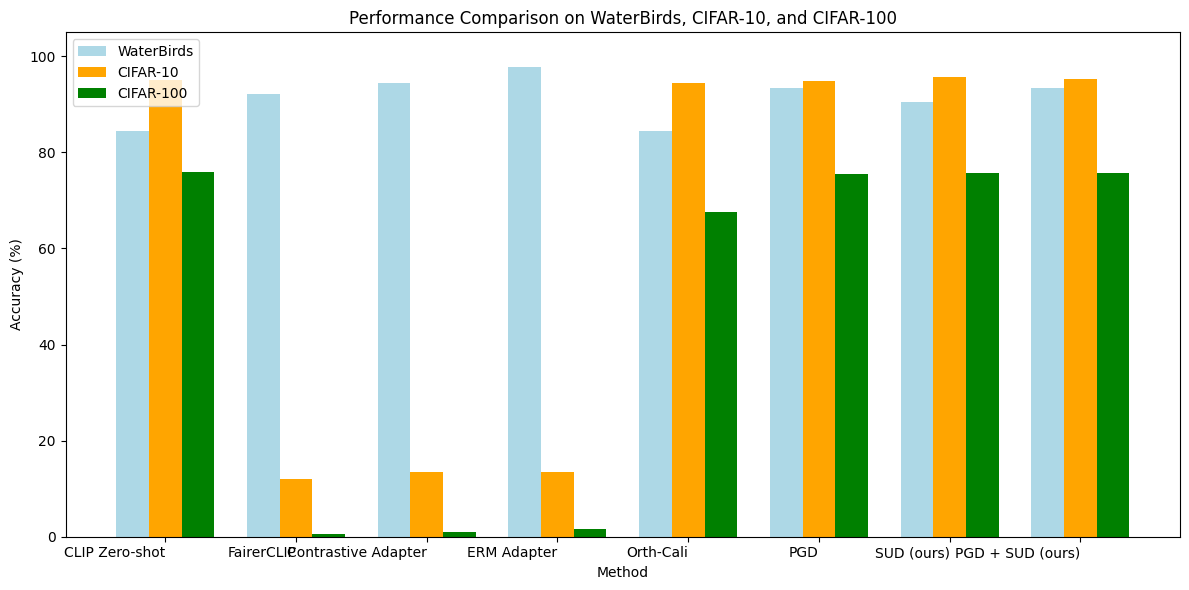

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
methods = [
    "CLIP Zero-shot", "FairerCLIP", "Contrastive Adapter", 
    "ERM Adapter", "Orth-Cali", "PGD", "SUD (ours)", "PGD + SUD (ours)"
]

waterbirds_acc = [84.4, 92.2, 94.5, 97.8, 84.5, 93.4, 90.4, 93.4]
cifar10_acc = [95.0, 12.1, 13.4, 13.4, 94.5, 94.9, 95.6, 95.3]
cifar100_acc = [76.0, 0.67, 1.0, 1.6, 67.6, 75.6, 75.7, 75.7]

x = np.arange(len(methods))  # X축의 위치

# 막대 너비
width = 0.25  

# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 6))

# 각각의 데이터셋에 대해 막대 설정
bar1 = ax.bar(x - width, waterbirds_acc, width, label='WaterBirds', color='lightblue')
bar2 = ax.bar(x, cifar10_acc, width, label='CIFAR-10', color='orange')
bar3 = ax.bar(x + width, cifar100_acc, width, label='CIFAR-100', color='green')



# Y축 범위 설정 (CIFAR 성능 차이를 강조하기 위해 범위 확대)
ax.set_ylim(0, 105)

# 그래프 세부 설정
ax.set_xlabel('Method')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Performance Comparison on WaterBirds, CIFAR-10, and CIFAR-100')
ax.set_xticks(x)
ax.set_xticklabels(methods, ha="right")
ax.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


In [11]:
kwargs

{'transform': <matplotlib.transforms.BboxTransformTo at 0x7f58a419e070>,
 'color': 'k',
 'clip_on': False}

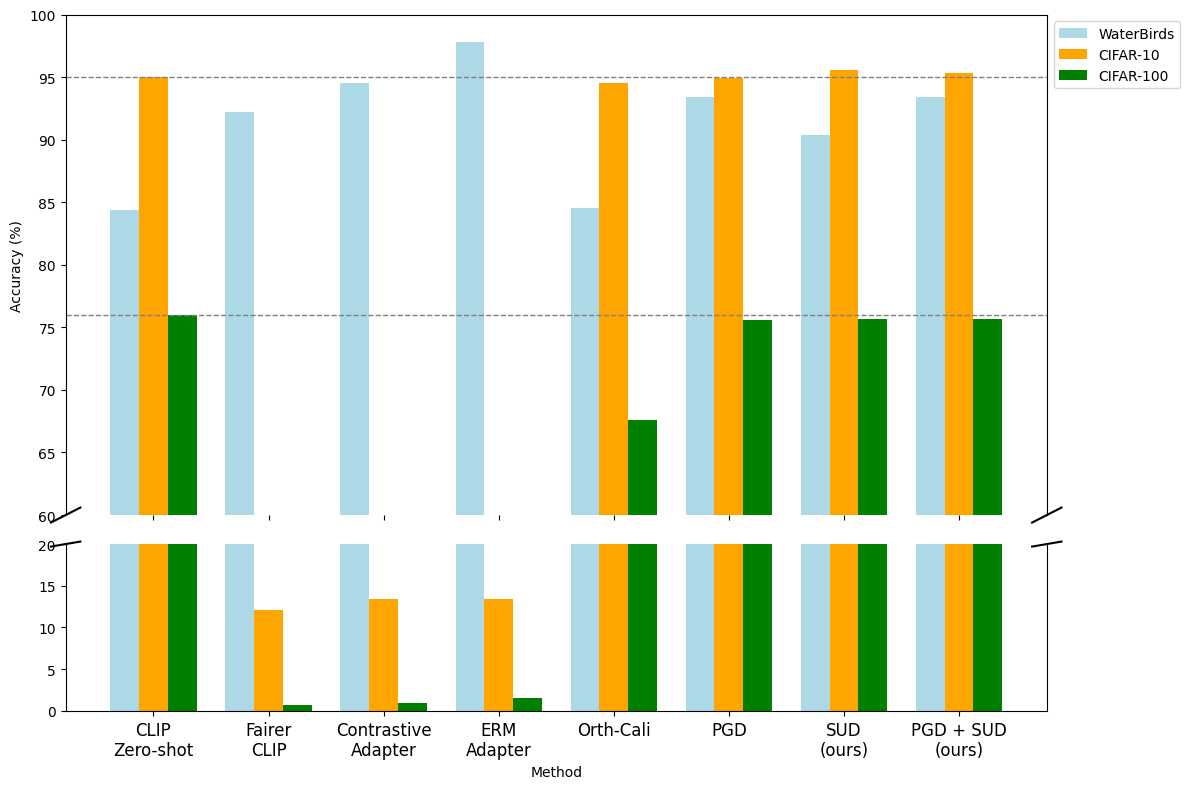

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
methods = [
    "CLIP\nZero-shot", "Fairer\nCLIP", "Contrastive\nAdapter", 
    "ERM\nAdapter", "Orth-Cali", "PGD", "SUD\n(ours)", "PGD + SUD\n(ours)"
]


waterbirds_acc = [84.4, 92.2, 94.5, 97.8, 84.5, 93.4, 90.4, 93.4]
cifar10_acc = [95.0, 12.1, 13.4, 13.4, 94.5, 94.9, 95.6, 95.3]
cifar100_acc = [76.0, 0.67, 1.0, 1.6, 67.6, 75.6, 75.7, 75.7]

x = np.arange(len(methods))  # X축의 위치
width = 0.25  # 막대 너비

# 그래프 그리기
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8),gridspec_kw={'height_ratios': [3, 1]})

# 첫 번째 축 (상단) - Y축 범위 60 이상
ax1.bar(x - width, waterbirds_acc, width, label='WaterBirds', color='lightblue')
ax1.bar(x, cifar10_acc, width, label='CIFAR-10', color='orange')
ax1.bar(x + width, cifar100_acc, width, label='CIFAR-100', color='green')
ax1.set_ylim(60, 100)  # 상단 범위 설정

# 두 번째 축 (하단) - Y축 범위 0에서 20까지
ax2.bar(x - width, waterbirds_acc, width, label='WaterBirds', color='lightblue')
ax2.bar(x, cifar10_acc, width, label='CIFAR-10', color='orange')
ax2.bar(x + width, cifar100_acc, width, label='CIFAR-100', color='green')
ax2.set_ylim(0, 20)  # 하단 범위 설정

# 물결 표시 (중간 생략을 나타내기 위해)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # 상단 축 눈금 비활성화
ax2.xaxis.tick_bottom()

d = .015  # 물결 크기
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # 상단 물결 표시
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # 상단 물결 표시

kwargs.update(transform=ax2.transAxes)  # 하단 물결 표시
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # 하단 물결 표시
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # 하단 물결 표시

# CIFAR-10 및 CIFAR-100에서 Zero-shot 기준으로 선을 그어 성능 비교
zero_shot_cifar10 = cifar10_acc[0]
zero_shot_cifar100 = cifar100_acc[0]
ax1.axhline(zero_shot_cifar10, color='gray', linestyle='--', linewidth=1)
ax1.axhline(zero_shot_cifar100, color='gray', linestyle='--', linewidth=1)

# Y축 눈금 5단위로 설정
ax1.yaxis.set_major_locator(plt.MultipleLocator(5.0))
ax2.yaxis.set_major_locator(plt.MultipleLocator(5.0))

# 범례를 그래프 바깥으로 이동
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 그래프 설정
ax2.set_xticks(x)
ax2.set_xticklabels(methods, ha="center", fontsize=12)
ax2.set_xlabel('Method')
ax1.set_ylabel('Accuracy (%)')

# 그래프 표시
plt.tight_layout()
plt.show()


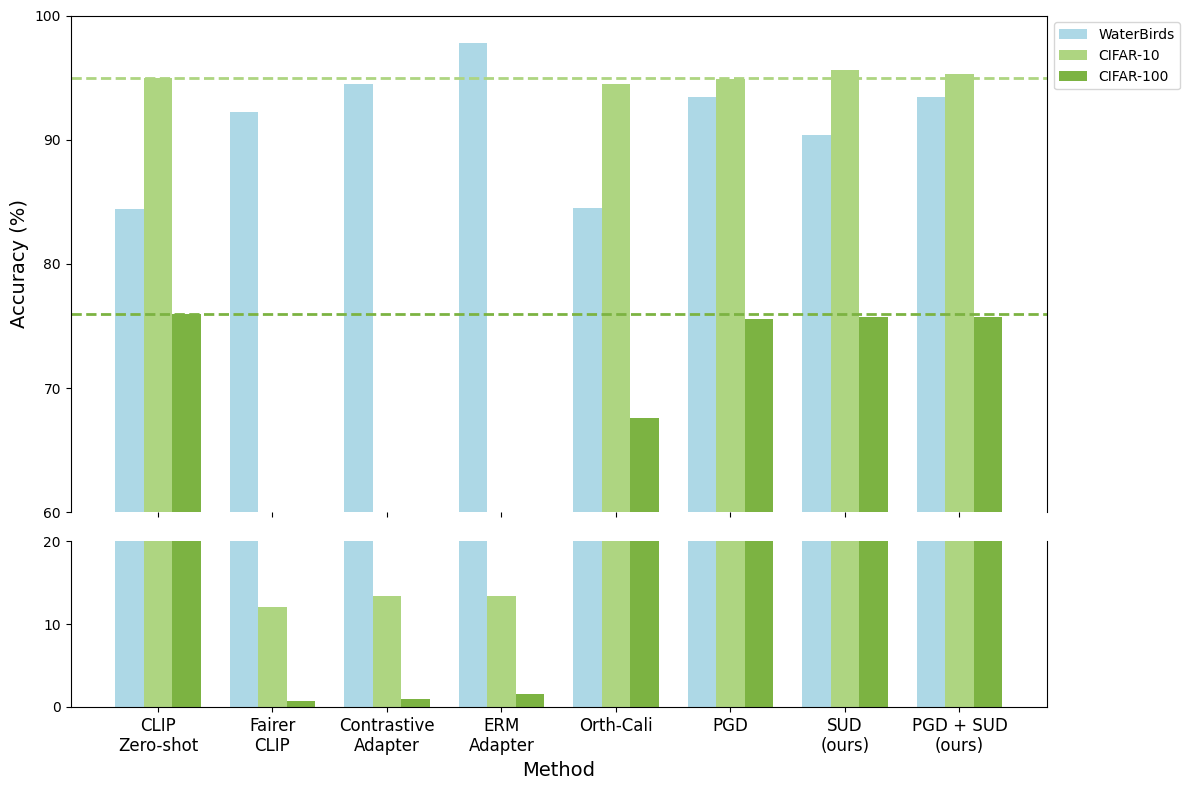

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
methods = [
    "CLIP\nZero-shot", "Fairer\nCLIP", "Contrastive\nAdapter", 
    "ERM\nAdapter", "Orth-Cali", "PGD", "SUD\n(ours)", "PGD + SUD\n(ours)"
]

waterbirds_acc = [84.4, 92.2, 94.5, 97.8, 84.5, 93.4, 90.4, 93.4]
cifar10_acc = [95.0, 12.1, 13.4, 13.4, 94.5, 94.9, 95.6, 95.3]
cifar100_acc = [76.0, 0.67, 1.0, 1.6, 67.6, 75.6, 75.7, 75.7]

x = np.arange(len(methods))  # X축의 위치
width = 0.25  # 막대 너비

# 그래프 그리기 (상단이 더 큰 비율로 영역을 차지하게 설정)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8),
                               gridspec_kw={'height_ratios': [3, 1]})  # 상단이 3배 더 큼
waterbirds_color = '#aed581'  # 흐린 연두색
# cifar10_color = '#64b5f6'    # 흐린 파란색
cifar10_color = '#aed581'
cifar100_color = '#7CB342'#'#8BC34A'# '#ffb74d'   # 흐린 주황색

# 첫 번째 축 (상단) - Y축 범위 60 이상
ax1.bar(x - width, waterbirds_acc, width, label='WaterBirds', color='lightblue')
ax1.bar(x, cifar10_acc, width, label='CIFAR-10', color=cifar10_color)
ax1.bar(x + width, cifar100_acc, width, label='CIFAR-100', color=cifar100_color)
ax1.set_ylim(60, 100)  # 상단 범위 설정

# 두 번째 축 (하단) - Y축 범위 0에서 60까지 (비율이 작음)
ax2.bar(x - width, waterbirds_acc, width, label='WaterBirds', color='lightblue')
ax2.bar(x, cifar10_acc, width, label='CIFAR-10', color=cifar10_color)
ax2.bar(x + width, cifar100_acc, width, label='CIFAR-100', color=cifar100_color)
ax2.set_ylim(0, 20)  # 하단 범위 설정

# 물결 표시 (상단 축과 하단 축을 구분하기 위해 물결 표시)
# ax1.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax1.tick_params(labeltop=False)  # 상단 축 눈금 비활성화
# ax2.xaxis.tick_bottom()

# d = .015  # 물결 크기
# kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
# ax1.plot((-d, +d), (-d, +d), **kwargs)  # 상단 물결 표시
# ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # 상단 물결 표시

# kwargs.update(transform=ax2.transAxes)  # 하단 물결 표시
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # 하단 물결 표시
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# 물결 표시 생략 (자연스럽게 이어지는 방식)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # 상단 축 눈금 비활성화
ax2.xaxis.tick_bottom()

# CIFAR-10 및 CIFAR-100에서 Zero-shot 기준으로 선을 그어 성능 비교
zero_shot_cifar10 = cifar10_acc[0]
zero_shot_cifar100 = cifar100_acc[0]
ax1.axhline(zero_shot_cifar10, color=cifar10_color, linestyle='--', linewidth=2)
ax1.axhline(zero_shot_cifar100, color=cifar100_color, linestyle='--', linewidth=2)

# Y축 눈금 5단위로 설정
ax1.yaxis.set_major_locator(plt.MultipleLocator(10.0))
ax2.yaxis.set_major_locator(plt.MultipleLocator(10.0))

# 범례를 그래프 바깥으로 이동
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 그래프 설정
ax2.set_xticks(x)
ax2.set_xticklabels(methods, rotation=0, ha="center", fontsize=12)  # 글자 수평, 크기 확대
ax2.set_xlabel('Method', fontsize=14)
ax1.set_ylabel('Accuracy (%)', fontsize=14)


# 그래프 표시
plt.tight_layout()
plt.show()


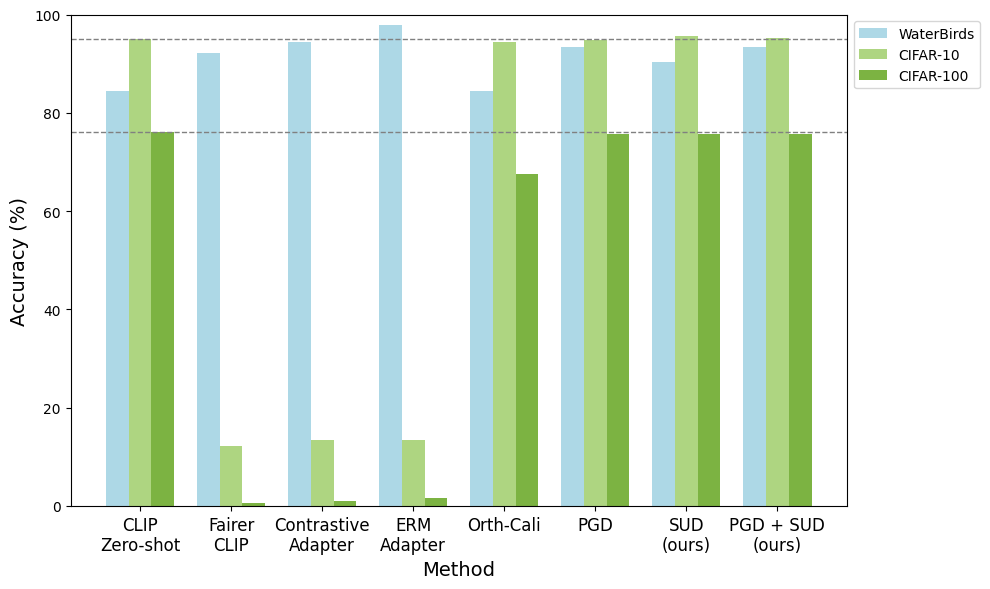

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
methods = [
    "CLIP\nZero-shot", "Fairer\nCLIP", "Contrastive\nAdapter", 
    "ERM\nAdapter", "Orth-Cali", "PGD", "SUD\n(ours)", "PGD + SUD\n(ours)"
]


waterbirds_acc = [84.4, 92.2, 94.5, 97.8, 84.5, 93.4, 90.4, 93.4]
cifar10_acc = [95.0, 12.1, 13.4, 13.4, 94.5, 94.9, 95.6, 95.3]
cifar100_acc = [76.0, 0.67, 1.0, 1.6, 67.6, 75.6, 75.7, 75.7]

waterbirds_color = '#aed581'  # 흐린 연두색
# cifar10_color = '#64b5f6'    # 흐린 파란색
cifar10_color = '#aed581'
cifar100_color = '#7CB342'#'#8BC34A'# '#ffb74d'   # 흐린 주황색

x = np.arange(len(methods))  # X축의 위치
width = 0.25  # 막대 너비

# # 색상 설정 (연두색을 더 진하게)
# waterbirds_color = '#8BC34A'  # 중간 연두색
# cifar10_color = '#64B5F6'    # 흐린 파란색
# cifar100_color = '#FFB74D'   # 흐린 주황색

# 그래프 그리기 (상단이 더 큰 비율로 영역을 차지하게 설정)
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 축 - Y축 범위 60 이상 강조
ax1.bar(x - width, waterbirds_acc, width, label='WaterBirds', color='lightblue')
ax1.bar(x, cifar10_acc, width, label='CIFAR-10', color=cifar10_color)
ax1.bar(x + width, cifar100_acc, width, label='CIFAR-100', color=cifar100_color)

# Y축 범위 조정: 60 이상 부분을 강조 (Zoom-in)
ax1.set_ylim(0, 100)  # Y축 범위를 0에서 100으로 설정, 60 이상 강조

# CIFAR-10 및 CIFAR-100에서 Zero-shot 기준으로 선을 그어 성능 비교
zero_shot_cifar10 = cifar10_acc[0]
zero_shot_cifar100 = cifar100_acc[0]
ax1.axhline(zero_shot_cifar10, color='gray', linestyle='--', linewidth=1)
ax1.axhline(zero_shot_cifar100, color='gray', linestyle='--', linewidth=1)

# Y축 눈금 5단위로 설정
ax1.yaxis.set_major_locator(plt.MultipleLocator(20.0))

# 범례를 그래프 바깥으로 이동
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 그래프 설정
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=0, ha="center", fontsize=12)  # 글자 수평, 크기 확대
ax1.set_xlabel('Method', fontsize=14)
ax1.set_ylabel('Accuracy (%)', fontsize=14)

# 그래프 표시
plt.tight_layout()
plt.show()


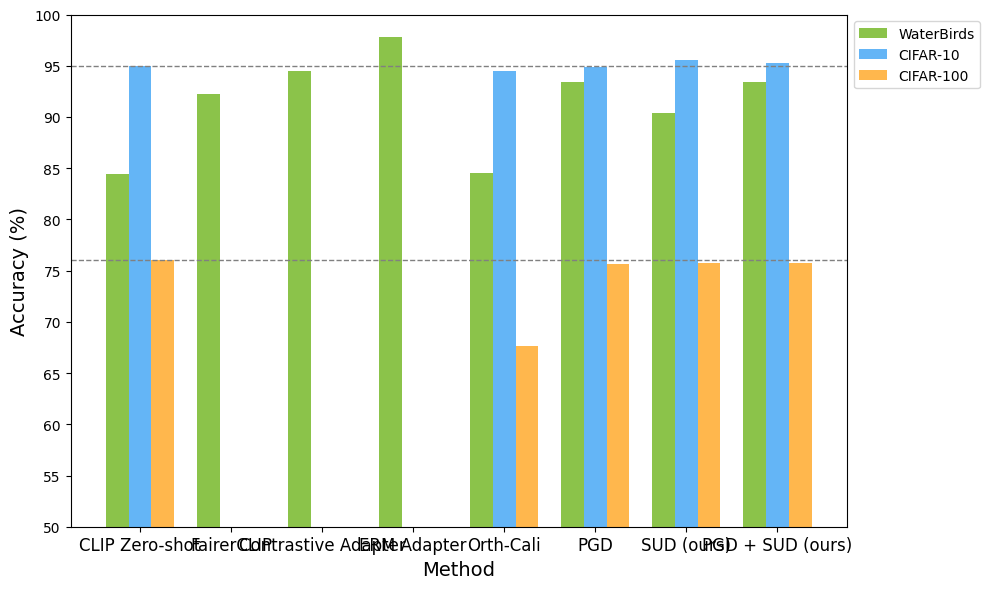

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
methods = [
    "CLIP Zero-shot", "FairerCLIP", "Contrastive Adapter", 
    "ERM Adapter", "Orth-Cali", "PGD", "SUD (ours)", "PGD + SUD (ours)"
]

waterbirds_acc = [84.4, 92.2, 94.5, 97.8, 84.5, 93.4, 90.4, 93.4]
cifar10_acc = [95.0, 12.1, 13.4, 13.4, 94.5, 94.9, 95.6, 95.3]
cifar100_acc = [76.0, 0.67, 1.0, 1.6, 67.6, 75.6, 75.7, 75.7]

x = np.arange(len(methods))  # X축의 위치
width = 0.25  # 막대 너비

# 색상 설정
waterbirds_color = '#8BC34A'  # 중간 연두색
cifar10_color = '#64B5F6'    # 흐린 파란색
cifar100_color = '#FFB74D'   # 흐린 주황색

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))

# 첫 번째 축 - Y축 범위 압축 및 강조
ax.bar(x - width, waterbirds_acc, width, label='WaterBirds', color=waterbirds_color)
ax.bar(x, cifar10_acc, width, label='CIFAR-10', color=cifar10_color)
ax.bar(x + width, cifar100_acc, width, label='CIFAR-100', color=cifar100_color)

# Y축 범위 조정: 상단을 강조하고 하단을 압축
ax.set_ylim(50, 100)  # 50 이상만 표시하여 하단 압축, 상단 강조

# CIFAR-10 및 CIFAR-100에서 Zero-shot 기준으로 선을 그어 성능 비교
zero_shot_cifar10 = cifar10_acc[0]
zero_shot_cifar100 = cifar100_acc[0]
ax.axhline(zero_shot_cifar10, color='gray', linestyle='--', linewidth=1)
ax.axhline(zero_shot_cifar100, color='gray', linestyle='--', linewidth=1)

# Y축 눈금 5단위로 설정
ax.yaxis.set_major_locator(plt.MultipleLocator(5.0))

# 범례를 그래프 바깥으로 이동
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 그래프 설정
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=0, ha="center", fontsize=12)  # 글자 수평, 크기 확대
ax.set_xlabel('Method', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)

# 그래프 표시
plt.tight_layout()
plt.show()


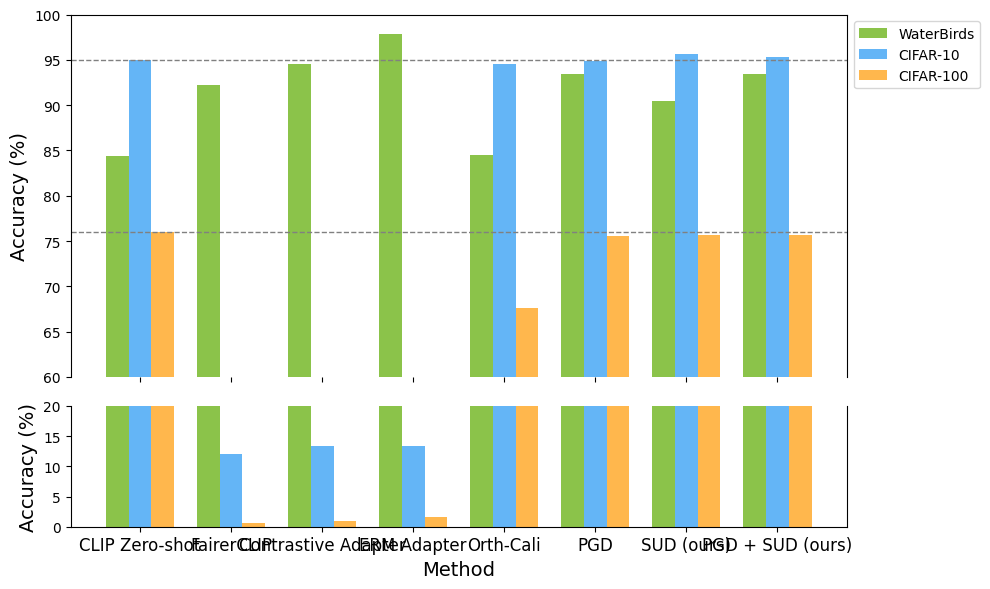

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
methods = [
    "CLIP Zero-shot", "FairerCLIP", "Contrastive Adapter", 
    "ERM Adapter", "Orth-Cali", "PGD", "SUD (ours)", "PGD + SUD (ours)"
]

waterbirds_acc = [84.4, 92.2, 94.5, 97.8, 84.5, 93.4, 90.4, 93.4]
cifar10_acc = [95.0, 12.1, 13.4, 13.4, 94.5, 94.9, 95.6, 95.3]
cifar100_acc = [76.0, 0.67, 1.0, 1.6, 67.6, 75.6, 75.7, 75.7]

x = np.arange(len(methods))  # X축의 위치
width = 0.25  # 막대 너비

# 색상 설정
waterbirds_color = '#8BC34A'  # 중간 연두색
cifar10_color = '#64B5F6'    # 흐린 파란색
cifar100_color = '#FFB74D'   # 흐린 주황색

# 그래프 그리기 (상단이 더 큰 비율로 영역을 차지하게 설정)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6),
                               gridspec_kw={'height_ratios': [3, 1]})  # 상단이 3배 더 큼

# 첫 번째 축 (상단) - Y축 범위 60 이상
ax1.bar(x - width, waterbirds_acc, width, label='WaterBirds', color=waterbirds_color)
ax1.bar(x, cifar10_acc, width, label='CIFAR-10', color=cifar10_color)
ax1.bar(x + width, cifar100_acc, width, label='CIFAR-100', color=cifar100_color)
ax1.set_ylim(60, 100)  # 상단 범위 설정

# 두 번째 축 (하단) - Y축 범위 0에서 60까지 (작은 값 표시)
ax2.bar(x - width, waterbirds_acc, width, label='WaterBirds', color=waterbirds_color)
ax2.bar(x, cifar10_acc, width, label='CIFAR-10', color=cifar10_color)
ax2.bar(x + width, cifar100_acc, width, label='CIFAR-100', color=cifar100_color)
ax2.set_ylim(0, 20)  # 하단 범위 설정

# 물결 표시 생략 (자연스럽게 이어지는 방식)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # 상단 축 눈금 비활성화
ax2.xaxis.tick_bottom()

# CIFAR-10 및 CIFAR-100에서 Zero-shot 기준으로 선을 그어 성능 비교
zero_shot_cifar10 = cifar10_acc[0]
zero_shot_cifar100 = cifar100_acc[0]
ax1.axhline(zero_shot_cifar10, color='gray', linestyle='--', linewidth=1)
ax1.axhline(zero_shot_cifar100, color='gray', linestyle='--', linewidth=1)

# Y축 눈금 5단위로 설정
ax1.yaxis.set_major_locator(plt.MultipleLocator(5.0))
ax2.yaxis.set_major_locator(plt.MultipleLocator(5.0))

# 범례를 그래프 바깥으로 이동
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 그래프 설정
ax2.set_xticks(x)
ax2.set_xticklabels(methods, rotation=0, ha="center", fontsize=12)  # 글자 수평, 크기 확대
ax2.set_xlabel('Method', fontsize=14)
ax1.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)

# 그래프 표시
plt.tight_layout()
plt.show()


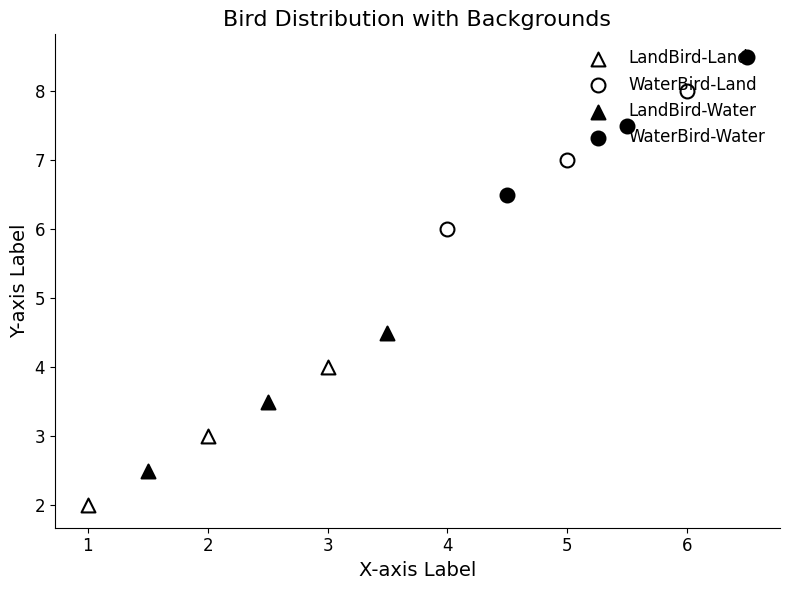

In [52]:
import matplotlib.pyplot as plt

# Coordinates for birds and backgrounds
land_bird_x = [1, 2, 3]
land_bird_y = [2, 3, 4]
water_bird_x = [4, 5, 6]
water_bird_y = [6, 7, 8]
land_background_x = [1.5, 2.5, 3.5]
land_background_y = [2.5, 3.5, 4.5]
water_background_x = [4.5, 5.5, 6.5]
water_background_y = [6.5, 7.5, 8.5]

# Plotting the points with shorter labels
plt.figure(figsize=(8, 6))

# LandBird with LandBackground (빈 세모)
plt.scatter(land_bird_x, land_bird_y, marker='^', s=100, label='LandBird-Land', facecolor='white', edgecolor='black', linewidth=1.5)
# WaterBird with LandBackground (빈 동그라미)
plt.scatter(water_bird_x, water_bird_y, marker='o', s=100, label='WaterBird-Land', facecolor='white', edgecolor='black', linewidth=1.5)

# LandBird with WaterBackground (채워진 세모)
plt.scatter(land_background_x, land_background_y, marker='^', s=100, label='LandBird-Water', facecolor='black', edgecolor='black', linewidth=1.5)
# WaterBird with WaterBackground (채워진 동그라미)
plt.scatter(water_background_x, water_background_y, marker='o', s=100, label='WaterBird-Water', facecolor='black', edgecolor='black', linewidth=1.5)

# Aesthetic improvements for axes and text
plt.xlabel('X-axis Label', fontsize=14)
plt.ylabel('Y-axis Label', fontsize=14)
plt.title('Bird Distribution with Backgrounds', fontsize=16)

# Setting ticks and labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a professional legend with shorter labels
plt.legend(loc='upper right', fontsize=12, frameon=False)

# Remove spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


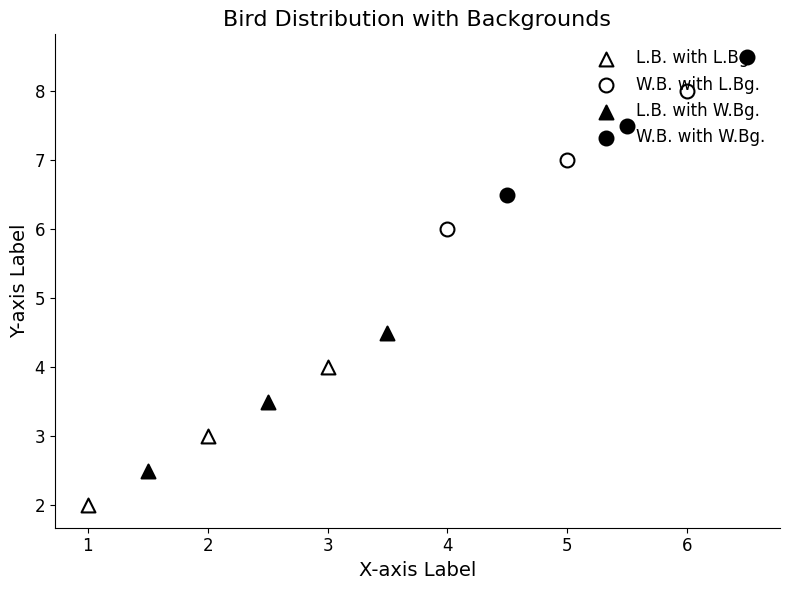

In [54]:
import matplotlib.pyplot as plt

# Coordinates for birds and backgrounds
land_bird_x = [1, 2, 3]
land_bird_y = [2, 3, 4]
water_bird_x = [4, 5, 6]
water_bird_y = [6, 7, 8]
land_background_x = [1.5, 2.5, 3.5]
land_background_y = [2.5, 3.5, 4.5]
water_background_x = [4.5, 5.5, 6.5]
water_background_y = [6.5, 7.5, 8.5]

# Plotting the points with simplified labels
plt.figure(figsize=(8, 6))

# LandBird with LandBackground (빈 세모)
plt.scatter(land_bird_x, land_bird_y, marker='^', s=100, label='L.B. with L.Bg.', facecolor='white', edgecolor='black', linewidth=1.5)
# WaterBird with LandBackground (빈 동그라미)
plt.scatter(water_bird_x, water_bird_y, marker='o', s=100, label='W.B. with L.Bg.', facecolor='white', edgecolor='black', linewidth=1.5)

# LandBird with WaterBackground (채워진 세모)
plt.scatter(land_background_x, land_background_y, marker='^', s=100, label='L.B. with W.Bg.', facecolor='black', edgecolor='black', linewidth=1.5)
# WaterBird with WaterBackground (채워진 동그라미)
plt.scatter(water_background_x, water_background_y, marker='o', s=100, label='W.B. with W.Bg.', facecolor='black', edgecolor='black', linewidth=1.5)

# Aesthetic improvements for axes and text
plt.xlabel('X-axis Label', fontsize=14)
plt.ylabel('Y-axis Label', fontsize=14)
plt.title('Bird Distribution with Backgrounds', fontsize=16)

# Setting ticks and labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a professional legend
plt.legend(loc='upper right', fontsize=12, frameon=False)

# Remove spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()
